### Airline Passengers Time Series Analysis

In this jupyter notebook, we will try to analyze the data we have regarding the monthly count of airline passengers from 1949 to 1961. Then, we will try to predict the count of passengers for month for the next 3 years.

Dataset: https://www.kaggle.com/datasets/andreazzini/international-airline-passengers

I will be importing the necessary libraries for analysis for now. I'll import the others for the forecast later on.

In [71]:
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

Import our csv:

In [72]:
df = pd.read_csv('international-airline-passengers.csv')
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


Rename the columns for analysis:

We will rename it again later upon using the Prophet library for our forecast.

In [73]:
df.columns = ['Month', 'Passengers (in Thousands)']
df.columns

Index(['Month', 'Passengers (in Thousands)'], dtype='object')

Check the following information about our data frame:
- shape (rows & columns)
- null values

In [74]:
# shape
print('Summary:\nDataframe has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

# null values
print('We have {} null value/s in the {} column and {} null value/s in our {} column.'.format(df.isnull().sum()[0], df.columns[0], df.isnull().sum()[1], df.columns[1]))

Summary:
Dataframe has 146 rows and 2 columns.
We have 1 null value/s in the Month column and 2 null value/s in our Passengers (in Thousands) column.


Check the location of the null values and drop if applicable:

In [75]:
df.isnull()

,Month,Passengers (in Thousands)
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
141,False,False
142,False,False
143,False,False
144,True,True


Null values are present from row 144 to 145. We will drop those columns.

In [76]:
df.dropna(inplace=True)
df.isnull().sum()

Month                        0
Passengers (in Thousands)    0
dtype: int64

Check data types:

In [77]:
df.dtypes

Month                         object
Passengers (in Thousands)    float64
dtype: object

Let's convert the Month column to datetime:

In [78]:
df['Month'] = pd.to_datetime(df['Month'])
df.dtypes

Month                        datetime64[ns]
Passengers (in Thousands)           float64
dtype: object

For now, let's set the Month as index.

In [79]:
df = df.set_index('Month')
df.head()

,Passengers (in Thousands)
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


Let's plot the data to see if there are obvious patterns or a recognizable trend.

<Axes: xlabel='Month'>

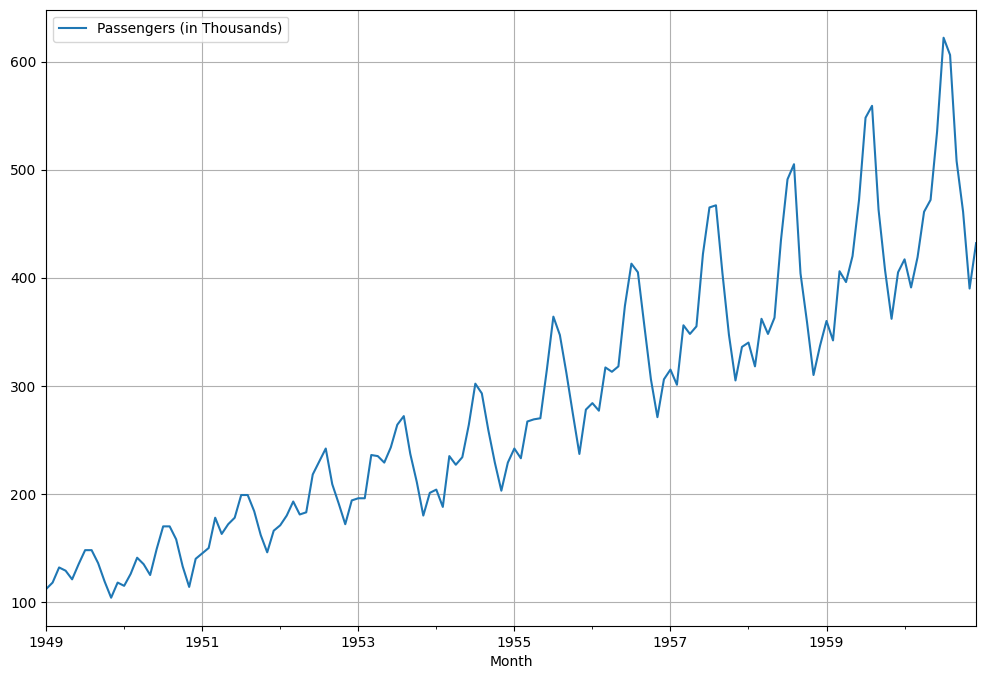

In [80]:
df.plot(grid='on')

Observations:
1. Over time, there is a visible upward trend in the overall passenger count.
2. We see a regular increase and decrease in the graph. There might be a seasonal pattern.

Let's check observation # 2 by looking at the most recent data more closely:

<Axes: xlabel='Month'>

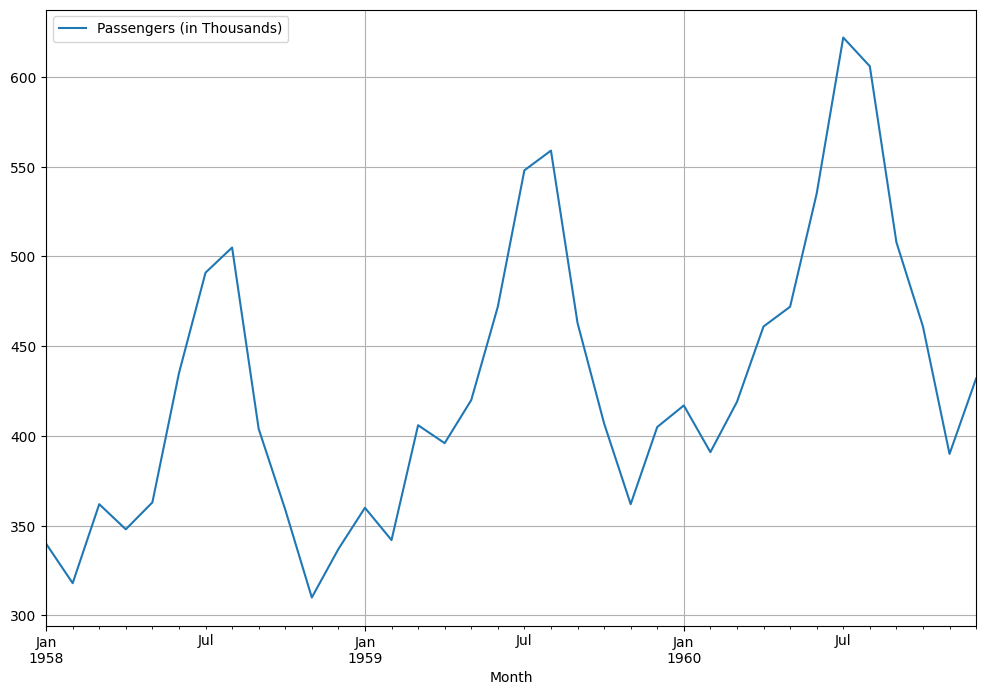

In [81]:
start_date = datetime(1958,1,1)
end_date = datetime(1960,12,1)
df[(start_date <= df.index) & (df.index <= end_date)].plot(grid='on')

We can see above that we have a seasonal trend. Spikes are seen every July to August and a steep decrease on the number of passengers during the last few months of the year.

#### Time Series Decomposition

We'll be using the additive model in this case.

Y(t) = Trend(t) + Seasonality(t) + Residual(t)

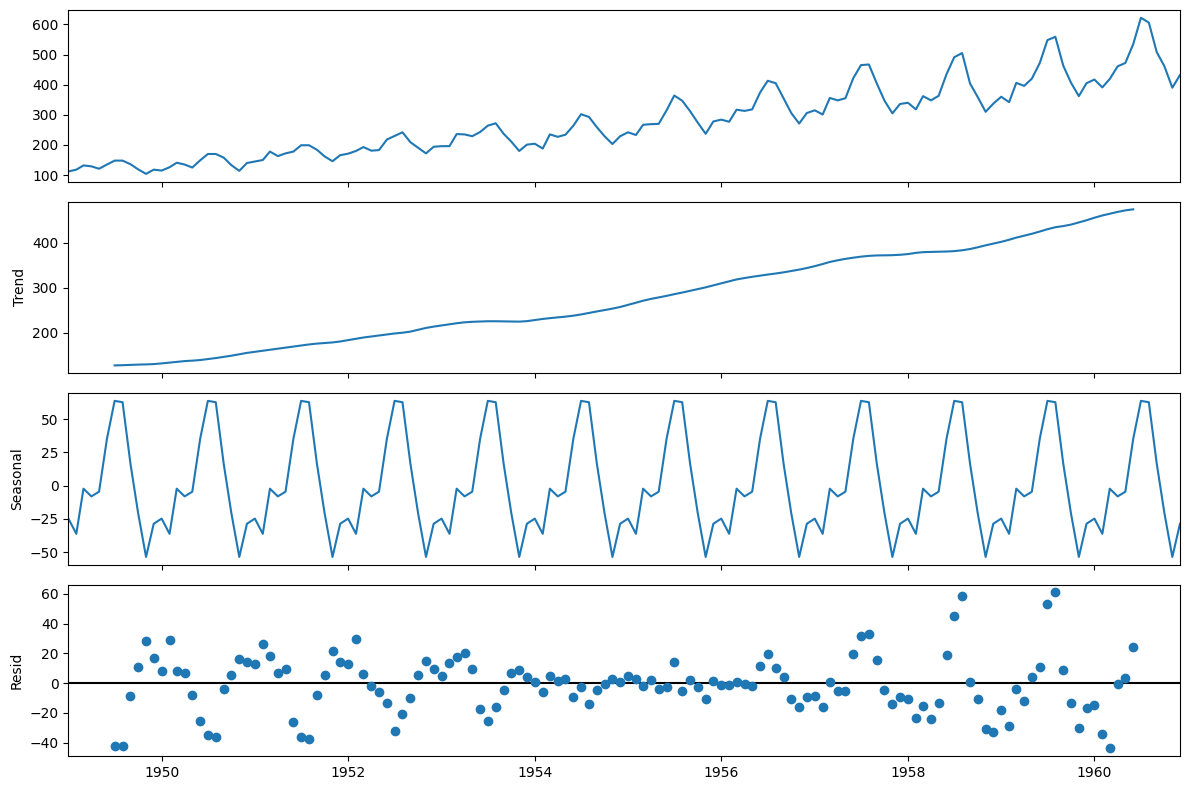

In [27]:
# residual - difference bet expectation and observation
decomposition = sm.tsa.seasonal_decompose(df, model = 'additive')
fig = decomposition.plot()

Looking at the Trend and Seasonality above, we can confirm our previous observations (trend going up, regular pattern on seasonality).

Let's plot the trend together with the observed time series:

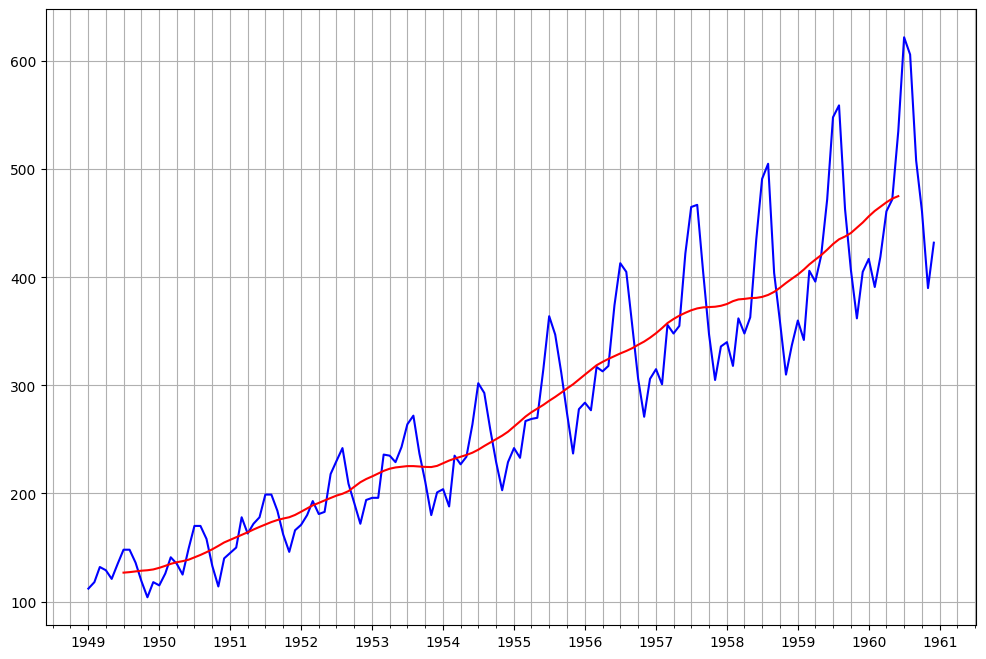

In [82]:
matplotlib.rcParams['figure.figsize'] = [12,8]
fig, ax = plt.subplots()
ax.grid(True)

year = mdates.YearLocator(month = 1)
month = mdates.MonthLocator(interval=3)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')

ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot(df.index, df['Passengers (in Thousands)'], c = 'blue')
plt.plot(decomposition.trend.index, decomposition.trend, c = 'red')

Looking at the final graph, we can confirm that
1. There is an overall upward trend in the number of airline passengers from 1949 to 1961.
2. There is a seasonal pattern for each year, which shows us a significant increase in the number of passengers around July to August (possibly summer) and a decrease in the late 3rd-4th quarter (possibly pre-winter to winter).

### Time Series Forecasting using Prophet

Import the Prophet library and rename the columns to 'ds' and 'y'.

In [83]:
from prophet import Prophet

In [84]:
df.reset_index(inplace = True)
df.columns = ['ds','y']
df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Let's fit the model by instantiating a new Prophet object.

In [85]:
model = Prophet()
model.fit(df)

14:26:33 - cmdstanpy - INFO - Chain [1] start processing
14:26:33 - cmdstanpy - INFO - Chain [1] done processing


Plotting the components enables us to see the trend and seasonal pattern, confirming our previous observations above.

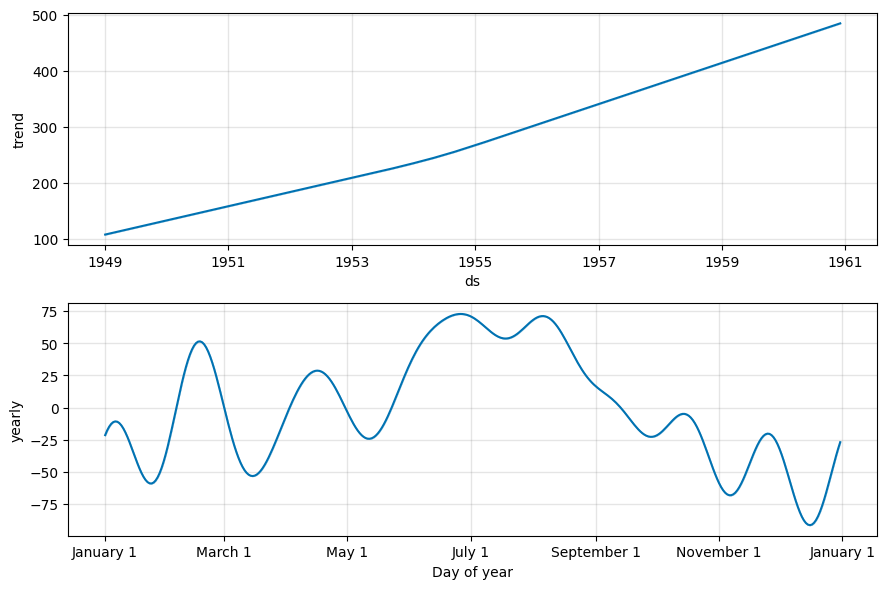

In [86]:
model.plot_components(model.predict(df));

Similar to our previous analysis, the number of passengers peaks around July every year.

### In-sample Data Forecast

We will slice our dataframe and fit the predict() function to the last few months of our data.

In [37]:
forecast = model.predict(df[132:])
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 1960-01-01  426.194986  396.956152  453.832585
1 1960-02-01  419.155644  390.197137  448.162618
2 1960-03-01  454.764993  425.754958  481.491941
3 1960-04-01  455.901746  423.587577  483.236060
4 1960-05-01  458.460963  431.919273  486.210584


In the data above, ds is the date of the forecasted value, yhat is the forecasted value, yhat_lower is the lower bound of our forecast, and yhat_upper is the upper bound of our forecast.

Let's plot it below to see if our model is good.

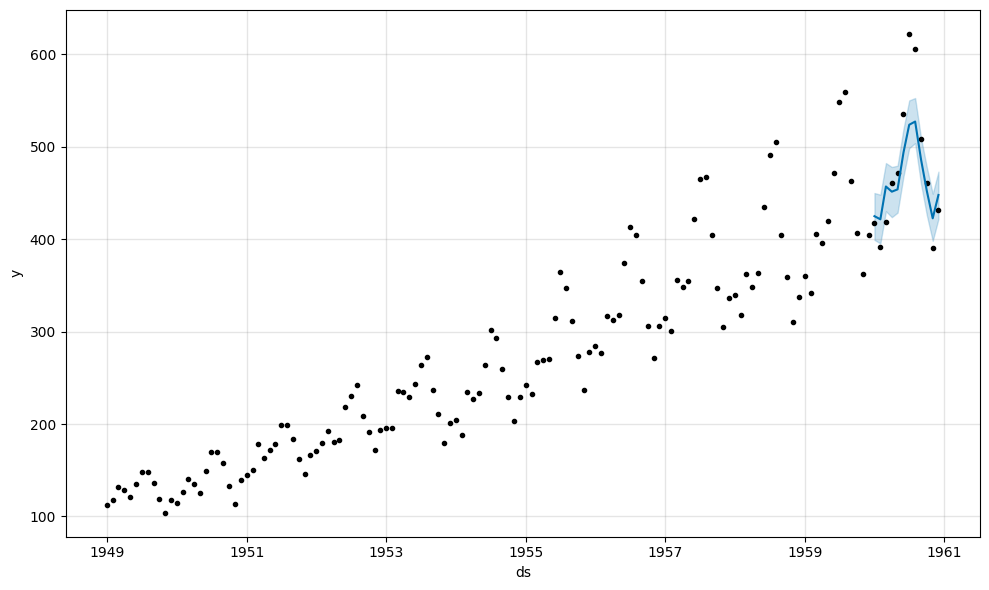

In [87]:
model.plot(forecast);

Legend:
Black dots are the training data, the blue represents the forecast, and the blue shaded area represents the upper and lower yhat.

We can consider the prediction to be close to the actual values.

### Out-of-sample Data Forecast

Let us now predict the number of passengers for the next 3 years.

In [47]:
# predictions are made on df column ds containing the dates for which a prediction is to be made (i used MS to match the frequency with our current data)
future = model.make_future_dataframe(periods = 12*3, freq = 'MS')
future.tail()

,ds
175,1963-08-01
176,1963-09-01
177,1963-10-01
178,1963-11-01
179,1963-12-01


Let's use the future dates as an input to the predict method of our fitted model

In [88]:
forecast = model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
175,1963-08-01,650.181732,621.643715,677.854272
176,1963-09-01,602.897520,575.258534,631.491888
177,1963-10-01,566.672579,537.205618,596.095519
178,1963-11-01,534.836844,506.422210,563.833943
179,1963-12-01,564.498004,536.391347,594.785721


#### Plotting the Forecast Results

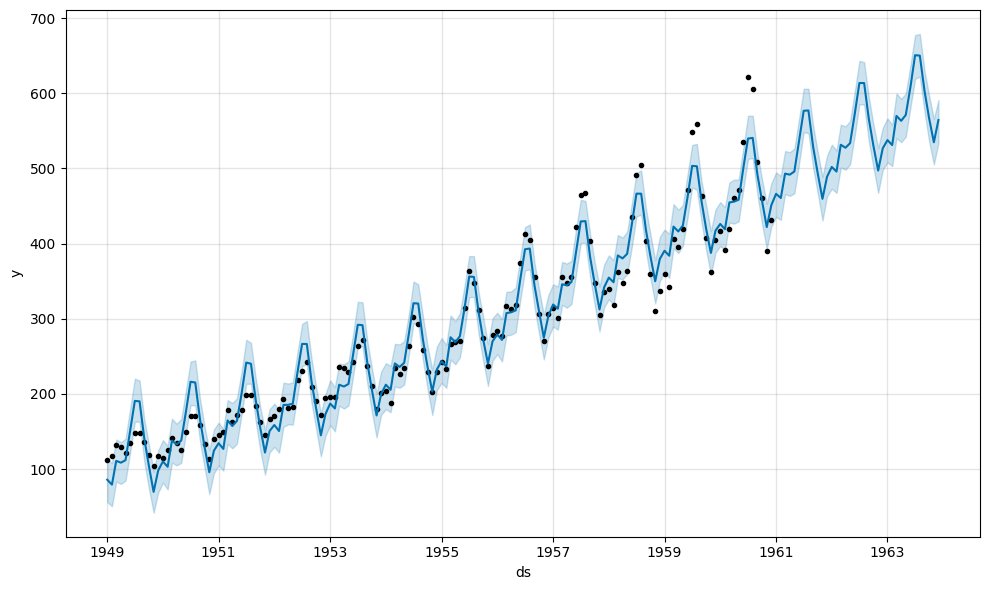

In [49]:
model.plot(forecast);

Prophet plots the observed values of our time series (black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (blue shaded regions). 

Note: uncertainty interval is 80% by default

Based on the graph above, our model seems to be good and inline with the past trend and seasonal patterns.

### Evaluation of the Model (Mean Absolute Error)

In [64]:
model = Prophet()
model.fit(df[:132])

forecast = model.predict(df[132:])

y_true = df['y'][132:].values
y_pred = forecast['yhat'].values

14:16:25 - cmdstanpy - INFO - Chain [1] start processing
14:16:25 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

MAE: 33.45


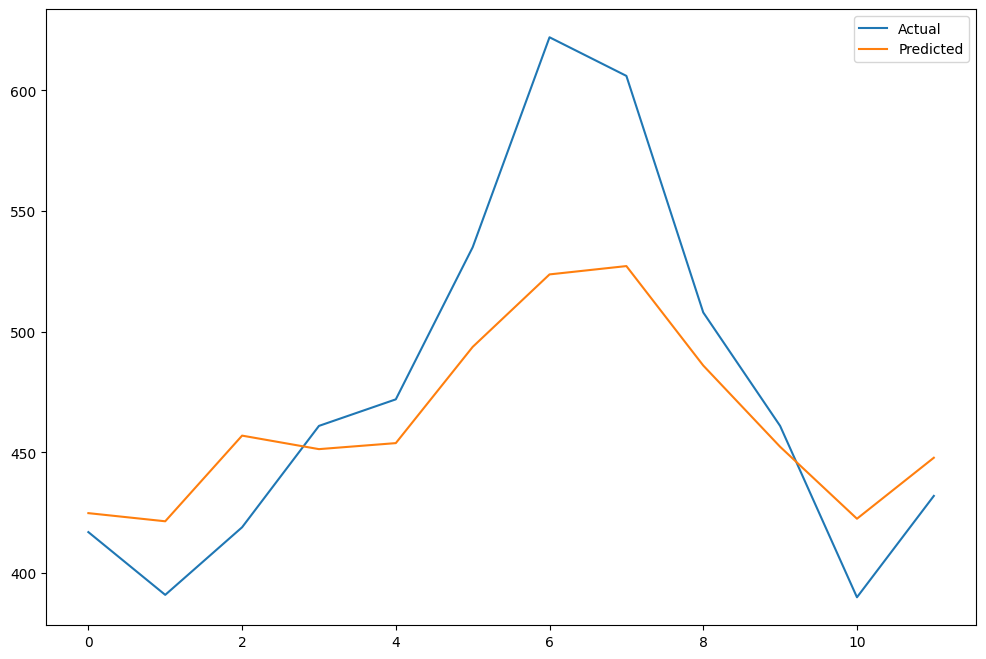

In [66]:
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.2f' % mae)
pyplot.plot(y_true, label = 'Actual')
pyplot.plot(y_pred, label = 'Predicted')
pyplot.legend()
pyplot.show()

MAE is within acceptable limits. Our model is good enough to see and capture the trend in our dataset.

Let's now check the final forecast values and export it to csv.

Our actual data ends at 1960-12-01 so the forecast will be 36 months of data starting from 1961-01-01.

In [97]:
results = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(36)
# change count of passenger prediction to int
results = results.astype({'yhat': int, 'yhat_lower': int, 'yhat_upper': int})
results

,ds,yhat,yhat_lower,yhat_upper
144,1961-01-01,466,437,495
145,1961-02-01,460,433,491
146,1961-03-01,493,462,520
147,1961-04-01,491,461,520
148,1961-05-01,496,466,523
149,1961-06-01,537,507,565
150,1961-07-01,576,548,603
151,1961-08-01,577,549,608
152,1961-09-01,528,500,558
153,1961-10-01,493,466,524


In [99]:
results.to_csv('airline-passengers-forecast.csv', index = False)

Now, we have our final monthly prediction for the next 3 years.